# Milestone 2 : How To Make a Hit Movie

Team members: ZHOU Xiao, LIU Jiafan

Abstract: Today, movies are basically the most popular type of art and entertainment for us. People go to the cinema to watch a movie or buy it on Amazon, and give reviews and ratings on it. But for movie makers, movies are a type of business. Some blockbusters like "Avatar" have earned billions of dollars, while a lot of other movies are not as lucky as the highest-grossing ones. So we may wonder how to make a hit movie. We will try to use data analysis to answer this question. From the matadata, reviews, ratings and even subtitles of movies, we would like to find factors and features that make a movie to become best seller on Amazon or take high revenues from the box office.

In [39]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy as sp
import json
import requests
import warnings
sns.set_context('notebook')
warnings.filterwarnings('ignore')

# 1. Data Loading and Preprocessing

# 1.1)  Amazon Data Loading and Preprocessing

In [2]:
import gzip
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)


In [3]:
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [4]:
reviews_raw = getDF('data/reviews_Movies_and_TV_5.json.gz')
reviews_raw.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


In [5]:
meta_raw = getDF('data/meta_Movies_and_TV.json.gz')
meta_raw.head()

,asin,categories,description,title,price,salesRank,imUrl,related,brand
0,0000143561,"[[Movies & TV, Movies]]","3Pack DVD set - Italian Classics, Parties and ...","Everyday Italian (with Giada de Laurentiis), V...",12.99,{'Movies & TV': 376041},http://g-ecx.images-amazon.com/images/G/01/x-s...,"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '...",NaN
1,0000589012,"[[Movies & TV, Movies]]",NaN,Why Don't They Just Quit? DVD Roundtable Discu...,15.95,{'Movies & TV': 1084845},http://ecx.images-amazon.com/images/I/519%2B1k...,"{'also_bought': ['B000Z3N1HQ', '0578045427', '...",NaN
2,0000695009,"[[Movies & TV, Movies]]",NaN,Understanding Seizures and Epilepsy DVD,NaN,{'Movies & TV': 1022732},http://g-ecx.images-amazon.com/images/G/01/x-s...,NaN,NaN
3,000107461X,"[[Movies & TV, Movies]]",NaN,Live in Houston [VHS],NaN,{'Movies & TV': 954116},http://ecx.images-amazon.com/images/I/41WY47gL...,NaN,NaN
4,0000143529,"[[Movies & TV, Movies]]",Disc 1: Flour Power (Scones; Shortcakes; South...,My Fair Pastry (Good Eats Vol. 9),19.99,{'Movies & TV': 463562},http://ecx.images-amazon.com/images/I/51QY79CD...,"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '...",NaN


# 1.2) TMDB Data Loading and Preprocessing

Load the TMDB credits data and TMDB movies data into pandas dataframes.

In [6]:
tmdb_credits_raw= pd.read_csv('data/tmdb_5000_credits.csv')
tmdb_movies_raw=pd.read_csv('data/tmdb_5000_movies.csv')

show the TMDB credits dataframe

In [7]:
tmdb_credits_raw.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


We can see the columns contained in credits dataframe, and the special index for a single film is movie_id. It contains cast and crew information.

Also, we show the dataframe of TMDB movies

In [8]:
tmdb_movies_raw.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


The dataframe also has a id column, corresponding to movie_id in previous one, and we can see there are many more information, which can process further analysis.

We merge the 2 dataframes and correspond each movie in one dataframe to the other, since they both have id features. After that,we show the columns of merged dataframe.

In [9]:
tmdb_credits_raw = tmdb_credits_raw.rename(columns= {'movie_id': 'id'})
tmdb_data_raw = pd.merge(tmdb_credits_raw, tmdb_movies_raw,on='id')
tmdb_data_raw.columns

Index(['id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count'],
      dtype='object')

We can see the features that the dataframe contains and we can implement data analysis upon that.

In [10]:
tmdb_data = tmdb_data_raw.rename(columns= {'title_x': 'title'})

First, we can see that in some columns, the information is contained in an unnormal structure, like json. Our first step is to recognise the columns and split the data structure to distill only the useful information.

In [11]:
import json
tmdb_json_columns = ['spoken_languages','genres', 'keywords', 'production_companies', 'production_countries', 'cast','crew']
for column in tmdb_json_columns:
    tmdb_data[column] = tmdb_data[column].apply(json.loads)
def splitName(column):
    temp_col = [[temp_row['name'] for temp_row in rows] for rows in column]
    return temp_col
tmdb_split_columns = ['spoken_languages','genres', 'keywords', 'production_companies', 'production_countries', 'cast']
for column in tmdb_split_columns:
    tmdb_data[column] = splitName(tmdb_data[column])

Now we can see the columns have been turned into a list, as we show in the preprocessed preocution_countries column. It will help us a lot in further data analysis.

In [12]:
tmdb_data['production_countries'].head()

0    [United States of America, United Kingdom]
1                    [United States of America]
2    [United Kingdom, United States of America]
3                    [United States of America]
4                    [United States of America]
Name: production_countries, dtype: object

There is an exception. We observe the crew column.

In [12]:
type(tmdb_data_raw['crew'][0])

str

Here is the crew information of only one movie, we can see there is plenty of jobs and plenty of information of that, so we can not just use use the method above to get only the names. We shall also correspond the name to their jobs.

In order to get the specific job in a crew feature, we define the function below to get the name from the specific job.

In [13]:
def getName(temp_row,job):
    temp_name=''
    for i in range(len(temp_row)):
        if temp_row[i]['job'] == job:
            temp_name = temp_row[i]['name']
            break 
    return temp_name

Here we get the name of main director and append it to the dataframe. It will help us to get the job information of a movie and it's much more convenient to implement analysis.

In [14]:
tmdb_data['director'] = [getName(temp_row,'Director') for temp_row in tmdb_data['crew']]
tmdb_data[['director']].head()

,director
0,James Cameron
1,Gore Verbinski
2,Sam Mendes
3,Christopher Nolan
4,Andrew Stanton


Also, we only take the year information of release_date.

In [15]:
tmdb_data['release_year'] = pd.to_datetime(tmdb_data['release_date']).dt.year
tmdb_data['release_year'].describe()

count    4802.000000
mean     2002.468763
std        12.414354
min      1916.000000
25%      1999.000000
50%      2005.000000
75%      2011.000000
max      2017.000000
Name: release_year, dtype: float64

Our topic is about how to make a hit movie, the goal of which is to explore how to make a movie as profitable as possible. 

In [16]:
tmdb_data['profit'] = (tmdb_data['revenue'] - tmdb_data['budget']) / tmdb_data['budget']
tmdb_data[['profit']].head()

,profit
0,10.763566
1,2.203333
2,2.594590
3,3.339756
4,0.092843


We can manually create a feature that judges whether the title of a movie has channged or not, determined by original_title and titile.

In [17]:
if_title_change= tmdb_data['original_title']==tmdb_data['title']
def judge_change(not_change):
    change=0
    if not_change: change=1
    return change
tmdb_data['title_change']= [judge_change(not_change) for not_change in if_title_change]

Also among the cast, we have to get the main actors or actresses since there are too many cast in one movie. The huge amount of vice actors and actresses will not bring a huge influence to a movie. So we only get the top 5 cast in a movie, which represents for the top main characters in a movie.

In [18]:
tmdb_data['cast']=[temp_cast[:5] for temp_cast in tmdb_data['cast']]

Now we show the columns after preprocessin of dataframe.

In [19]:
tmdb_data.columns

Index(['id', 'title', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count', 'director',
       'release_year', 'profit', 'title_change'],
      dtype='object')

To implement our topic and approach,we will use corresponding features to analyze what features make a hit movie. We manually drop the columns that will not take a casual effect of a hit movie and clean the dataframe.

In [20]:
temp_drop_col=['crew','original_title','overview','id','homepage','status','tagline','title_y','release_date']
tmdb_data = tmdb_data.drop(temp_drop_col, axis=1)

Here we finish doing simple data wrangling and the preprocessed TMDB dataframe is what we want for future analysis.

In [21]:
tmdb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 18 columns):
title                   4803 non-null object
cast                    4803 non-null object
budget                  4803 non-null int64
genres                  4803 non-null object
keywords                4803 non-null object
original_language       4803 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
director                4803 non-null object
release_year            4802 non-null float64
profit                  3913 non-null float64
title_change            4803 non-null int64
dtypes: float64(5), int64(4), object(9)
memory usage: 712.9+ KB


# 1.3) Merging Amazon Data and TMDB Data

Above we finish the sepeate prepreocessing of amazon data and TMDB data. Our final goal is to use the all informative features to analyze how to make a hit movie. In this section, we merge the data for further deep analysis, which will be implemented until Milestone 3.

In [22]:
merge_raw= pd.merge(tmdb_data, meta_raw,on='title')
merge_raw=pd.merge(merge_raw, reviews_raw,on='asin')
merge_raw.head()

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,related,brand,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,NaN,NaN,A2JJ0KQTN8QED3,Bap8494,"[4, 4]",I can't understand why I haven't heard more ab...,5.0,Shocking!!,1332115200,"03 19, 2012"
1,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,NaN,NaN,A35Z5BLHL9CI8P,"Charlene ""divercity@interia.pl""","[2, 4]","It's definitely a must-see. Very climatic, mys...",5.0,"Great acting, great plot, great movie",1125360000,"08 30, 2005"
2,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,NaN,NaN,A19RAJY6R7USN0,"Lee Neville ""emotionboy""","[4, 6]",Rachael Leigh Cook stars and looks amazing in ...,2.0,Tangled movie,1048809600,"03 28, 2003"
3,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,NaN,NaN,A3R36DZQEWNVJ1,Mike Bolts,"[2, 5]","Shawn Hatosy (The Faculty, Outside Providence)...",1.0,Tangled gets tangled in its own self......a bi...,1130630400,"10 30, 2005"
4,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,NaN,NaN,A29Q1SCC4OCO67,mypetconcubine,"[14, 15]",Tangled is a smart and edgy thriller with a ta...,4.0,Love Triangle Thriller,1114473600,"04 26, 2005"


We merge the dataframe due to the shared name of movie while 2 amazon datasets are merged by asin feature speified in amazon database.

In [29]:
merge_raw=merge_raw.drop(['description','imUrl','brand','salesRank'],axis=1)
merge_raw.head()

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,price,related,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A2JJ0KQTN8QED3,Bap8494,"[4, 4]",I can't understand why I haven't heard more ab...,5.0,Shocking!!,1332115200,"03 19, 2012"
1,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A35Z5BLHL9CI8P,"Charlene ""divercity@interia.pl""","[2, 4]","It's definitely a must-see. Very climatic, mys...",5.0,"Great acting, great plot, great movie",1125360000,"08 30, 2005"
2,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A19RAJY6R7USN0,"Lee Neville ""emotionboy""","[4, 6]",Rachael Leigh Cook stars and looks amazing in ...,2.0,Tangled movie,1048809600,"03 28, 2003"
3,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A3R36DZQEWNVJ1,Mike Bolts,"[2, 5]","Shawn Hatosy (The Faculty, Outside Providence)...",1.0,Tangled gets tangled in its own self......a bi...,1130630400,"10 30, 2005"
4,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A29Q1SCC4OCO67,mypetconcubine,"[14, 15]",Tangled is a smart and edgy thriller with a ta...,4.0,Love Triangle Thriller,1114473600,"04 26, 2005"


In [30]:
merge_raw.columns

Index(['title', 'cast', 'budget', 'genres', 'keywords', 'original_language',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'vote_average', 'vote_count', 'director',
       'release_year', 'profit', 'title_change', 'asin', 'categories', 'price',
       'related', 'reviewerID', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

We can get the informative feature columns for the final merged dataframe, and we will implement detailed analysis upon them.

# 1.4) Generate pickle file

In [25]:
tmdb_data.to_pickle('tmdb_data.pkl')
merge_raw.to_pickle('merge_raw.pkl')

We save the preprocessed dataframe to a generated pickle file, which is more efficient for later data analysis.

# 2. Amazon Descriptice Statistical Analysis

# 3. TMDB Descriptice Statistical Analysis

# 3.1) TMDB Movie Genre Evoluation 

To make a hit movie, in addtion to simple numbers like budget and popularity, other text information is also informative. For example, the genres have a huge influence of movie reviews. In typical years , specific genres of movie tend to lead a fashion.

We get the evoluation plot of all types of movie with time above.

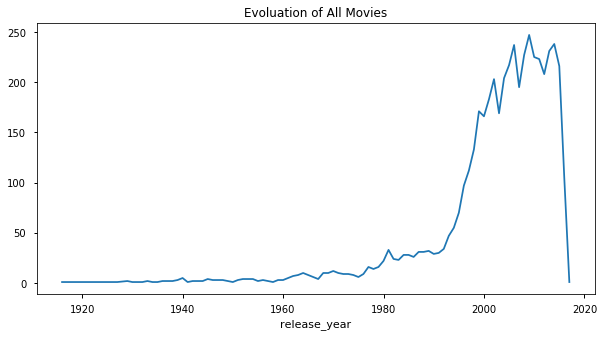

In [26]:
tmdb=tmdb_data.copy()
tmdb_by_year = tmdb.groupby('release_year').size().plot(figsize=(10,5),title='Evoluation of All Movies')

We can see that agter 2000, the number of movies has a explosive increase.

We define a get_count function to get the count of each element in a list feature. The function can be used later not limitted to genres information, but also other preprocessed columns like spoken_launguages and procution_countries.

In [10]:
def get_count(col):
    temp_count = dict()
    for row in col:
        for temp_feature in row:
            if temp_feature in temp_count:
                temp_count[temp_feature] += 1
            else:
                temp_count[temp_feature] = 1
    return temp_count

In [9]:
def get_count(col):
    temp_count = dict()
    for row in col:
        for temp_feature in row:
            if temp_feature in temp_count:
                temp_count[temp_feature] += 1
            else:
                temp_count[temp_feature] = 1
    return temp_count
genres_count = pd.Series(get_count(tmdb['genres'])).sort_values(ascending=False)
genres_count

NameError: name 'tmdb' is not defined

Now we c get the number of each genre of movies with their count number in a descending order.

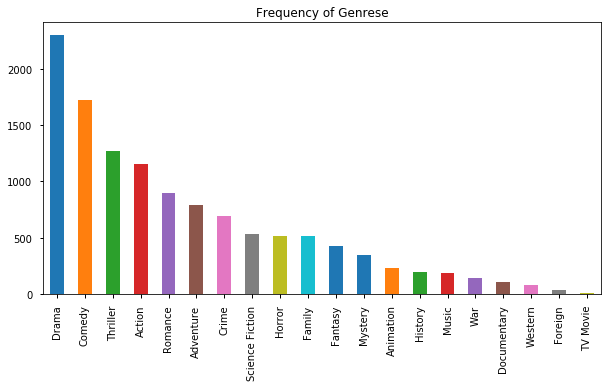

In [28]:
genres_count.plot(kind = 'bar', title = 'Frequency of Genrese',figsize=(10,5))

We get the bar chart of 20 genres of movies with their count number. We can see the Drama account for most.

Then we wish to observe the evoluation of each genre with time. We creae a new dataset with genres as its columns and releasr_year as its index, We can easily get the acount in the genre and get the resulted dataframe.

In [29]:
genres_by_year = tmdb.groupby('release_year').genres.sum()
genres_stat = pd.DataFrame([], index = genres_by_year.index, columns = genres_count.index[0:20])
for temp_year in genres_stat.index:
    for temp_genre in genres_stat.columns:
        genres_stat.loc[temp_year,temp_genre] = genres_by_year[temp_year].count(temp_genre) 
genres_stat.head()

,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Science Fiction,Horror,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie
release_year,,,,,,,,,,,,,,,,,,,,
1916.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1925.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1927.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1929.0,2,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1930.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


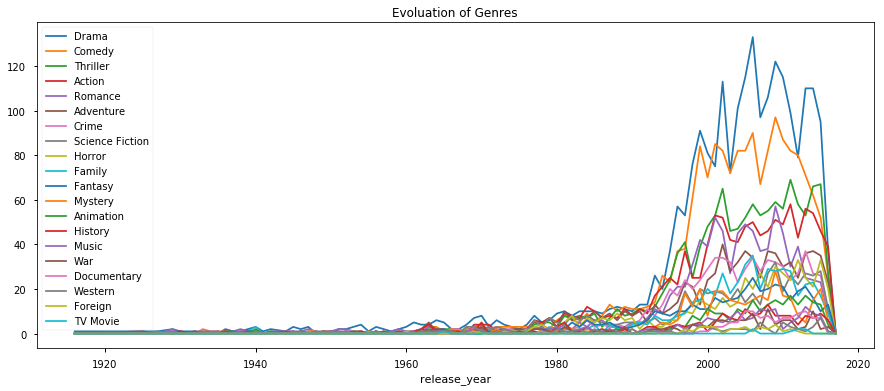

In [30]:
genres_stat.plot(figsize=(15,6),title='Evoluation of Genres')

We plot the evoluation of genres of movies with time. We can see that drama has always been a leading trend in history, followed by comedy. The trend of other genres have been fluctuating through time and market of movies for that are usually changing.

# 3.2) Geographic Distribution

Then we focus on the production countries of movies. Since different countries lead to different cultures and different strengths of countries can lead to different tastes of movies. For example, America is famous for its technology and thus Ameican science fiction movies often take more budget, but they may lead to higher ratings in the other hand. Japan is famous for its worldwide animations and Japanese anaimations often take a large percentage in the market.

In [31]:
country_count = pd.Series(get_count(tmdb['production_countries'])).sort_values(ascending=False)
country_count_df=pd.DataFrame(country_count)
country_count_df['country']=country_count_df.index
country_count_df['count']=country_count_df[0]
country_count_df.reset_index(inplace=True)
country_count_df=country_count_df[['country','count']]
country_count_df.head(10)

,country,count
0,United States of America,3956
1,United Kingdom,636
2,Germany,324
3,France,306
4,Canada,261
5,Australia,110
6,Italy,72
7,Spain,71
8,China,59
9,Japan,58


We use the get_count function again to get the count of each potential countries and get the couts in a descending order.

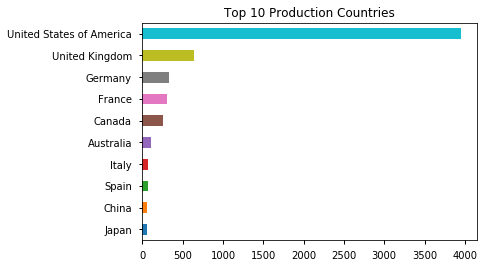

In [63]:
country_count_show=country_count[:10]
country_count_show=country_count_show[::-1]
country_count_show.plot(kind='barh',title='Top 10 Production Countries')

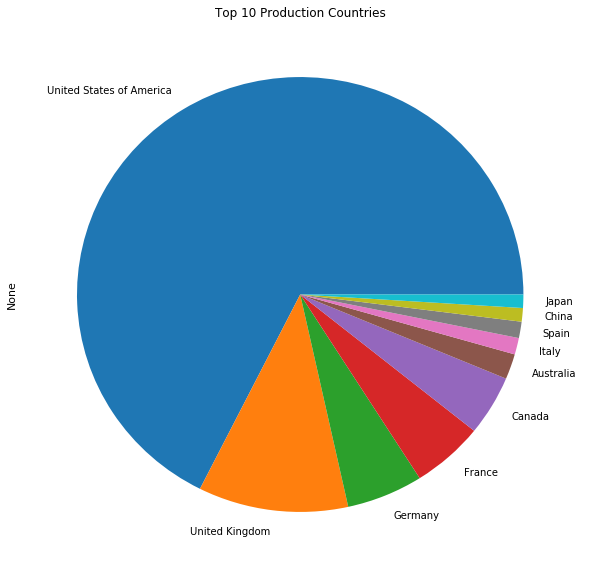

In [64]:
country_count_show_2=country_count[:10]
country_count_show_2.plot(kind='pie',figsize=(10,10),title='Top 10 Production Countries')

Also, we get a horizental bar chart and a pie chart to observe the geographic distribution of movies. We can see in tmdb datasets, there are many more American movies than other countries, followed by United Kindoms and Germany.

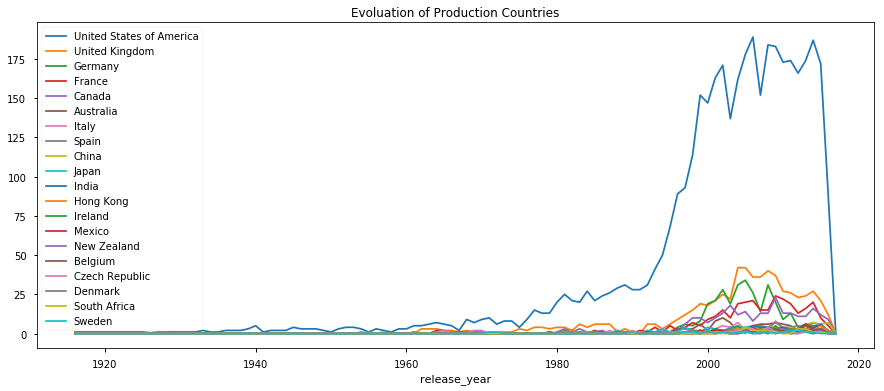

In [34]:
country_by_year = tmdb.groupby('release_year').production_countries.sum()
country_stat = pd.DataFrame([], index = country_by_year.index, columns = country_count.index[0:20])
for temp_year in country_stat.index:
    for temp_country in country_stat.columns:
        country_stat.loc[temp_year,temp_country] = country_by_year[temp_year].count(temp_country) 
country_stat.plot(figsize=(15,6),title='Evoluation of Production Countries')

We plot the evoluation of production countries of movies with time. We can see that America has always been the leading country in movie industry, followed by United Kindom. The trend of other countries have been flucuating through time and market of movies for that are usually changing.But we can observe that the overall trend is that the numbers of all movies a country makes has been in an increase trend in history despite the overall decrease trend in recent years.

Later, we plan to correlate the geographic information with other features in hit movie analysis in section 4 and we plan to utilize folium to show the correlation with other features in the world map, which is more visually readable.

# 3.3) Language and Company Distribution

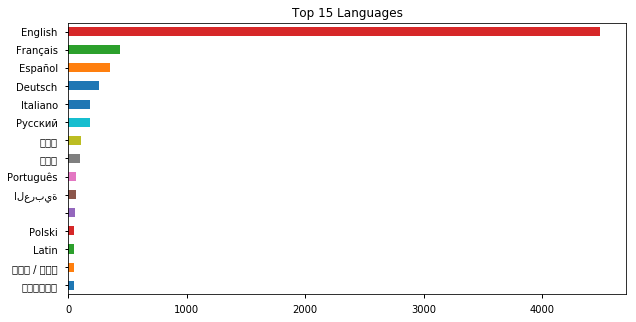

In [35]:
language_count = pd.Series(get_count(tmdb['spoken_languages'])).sort_values(ascending=False)
language_count_show=language_count[:15]
language_count_show=language_count_show[::-1]
language_count_show.plot(kind='barh',figsize=(10,5),title='Top 15 Languages')

We observe English is the dominant Language in tmdb movies.

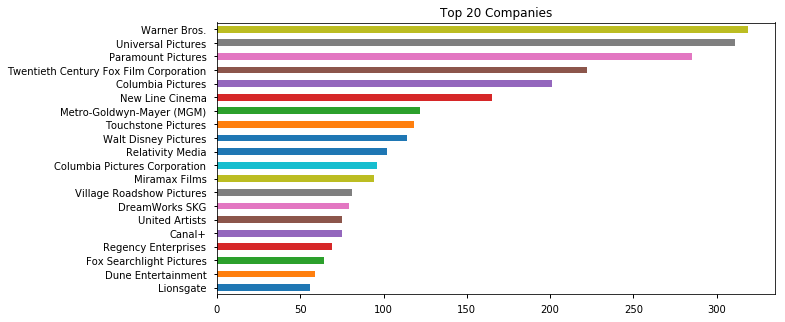

In [36]:
company_count = pd.Series(get_count(tmdb['production_companies'])).sort_values(ascending=False)
company_count_show=company_count[:20]
company_count_show=company_count_show[::-1]
company_count_show.plot(kind='barh',figsize=(10,5),title='Top 20 Companies')

We can get the top popular spoken launguages and production companies as above. In case of contingency, the top mamebers will be utilized in future detailed analysis.

# 3.4) Inflence of Celebrity

Besides genres and production countries, there are some other features that also bring a huge difference to a movie rating, like spoken launguages. In this section,we focus on the influence of celebrity. We wish to oberve whether a famous person who participate in the movie will have an influence on the movie.

Usually there are lots of jobs involved in movie productions, like casts, directors, producer, 3D direrecot and so on. However, the way of getting a cast influence is the same as genres and production countires as above due to the same data strcture of list in dataframe features. So we put our focus on famous people in crew. Since there are too many jobs in crew, we choose directors for analysis since a director can influence the story line and overall prensentation of a movie.

In [37]:
def get_direcotr_count(col):
    temp_count = dict()
    for temp_director in col:
            if temp_director in temp_count:
                temp_count[temp_director] += 1
            else:
                temp_count[temp_director] = 1
    return temp_count

First, we define a function get_director_count to get the dictionary of each director in the dataset and their corresponding count.

In [117]:
director_count = pd.Series(get_direcotr_count(tmdb['director'])).sort_values(ascending=False)
director_count=director_count[1:]
director_count_df=pd.DataFrame(director_count)
director_count_df['director']=director_count_df.index
director_count_df['count']=director_count_df[0]
director_count_df.reset_index(inplace=True)
director_count_df=director_count_df[['director','count']]
director_count_df.head(10)

,director,count
0,Steven Spielberg,27
1,Woody Allen,21
2,Clint Eastwood,20
3,Martin Scorsese,20
4,Robert Rodriguez,16
5,Spike Lee,16
6,Ridley Scott,16
7,Renny Harlin,15
8,Steven Soderbergh,15
9,Oliver Stone,14


We then turn the count into a dataframe in a descending order and show the distribution in a horizontal bar chart.

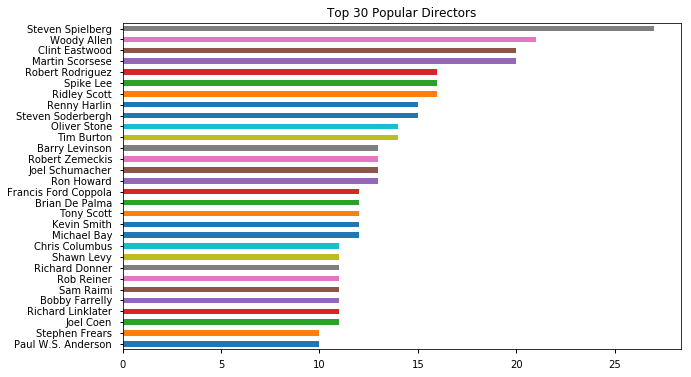

In [118]:
director_count_show=director_count.head(30)
director_count_show=director_count_show[::-1]
director_count_show.plot(figsize=(10,6),kind='barh',title='Top 30 Popular Directors')

The number of movies each director directs is shown above. It shows the popularity of top 30 popular directors.

However, the influence of a director is not only shown by how many movies he/she directs, it's also shown by how many revenue he can bring to a movie, and that's considered as a key part of a hit movie.

We then sum the total revenue of all movies a director directs and show the total_revenue in following dataframe.

In [119]:
director_count_df['total_revenue']=0
for temp_director in director_count_df.director:
    total_tmdb_temp_director=tmdb[tmdb['director']==temp_director]
    temp_total_revenue=total_tmdb_temp_director.revenue.sum()
    temp_index=director_count_df[director_count_df['director']==temp_director].index
    director_count_df.total_revenue[temp_index]=total_tmdb_temp_director.revenue.sum()
director_count_df.head()

,director,count,total_revenue
0,Steven Spielberg,27,9147393164
1,Woody Allen,21,669101038
2,Clint Eastwood,20,2512058888
3,Martin Scorsese,20,1956635998
4,Robert Rodriguez,16,1109899581


We use total_revenue/count to calculate the average revenue a director bring to a movie. Since a director who participates in only  a few movies do not contain much information, we choose the top 20 directors with their average revenue and show the result below with a dataframe and a horizontal chart.

<BarContainer object of 20 artists>

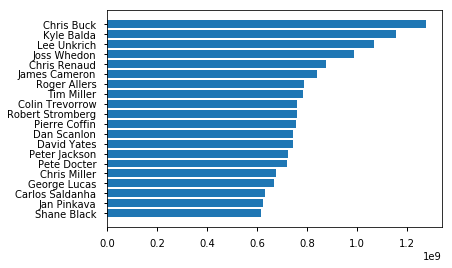

In [121]:
director_df=director_count_df.copy()
director_df['avg_revenue']=director_df['total_revenue']/director_df['count']
director_df=director_df.sort_values(by='avg_revenue',ascending=False)

director_df=director_df.reset_index()
director_df=director_df[['director','avg_revenue']]
director_df=director_df.head(20)
temp_x=director_df['avg_revenue']
temp_x=temp_x[::-1]
temp_y=director_df['director']
temp_y=temp_y[::-1]
plt.barh(temp_y,temp_x)

In this section, we get the number of movies and average revenue of each director and show the result by plots. We will further correlate the information with other feature in machine learning and other approaches in later section in 4. 

# 3.5) Simple Keywords Analysis

Keyword is also an important element that representsn for the theme of a movie and it's worth analyzing in deep text processing domain like natural language preocessing. In the task of descriptive statiscs, we use wordcloud library to show the frequencey of each potential keyword and plot it above.

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Here we show the total keywords among all movies in datasets. The keywords plot can be different if we divide movies by genres, countries and directors, but the approach is all the same, we will further correlate the features in merged data in section 4 until milestone 3.

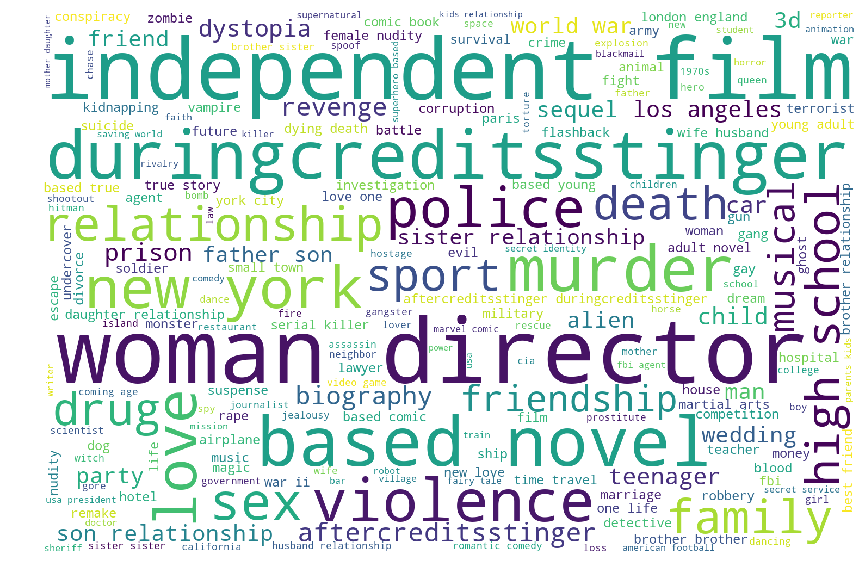

In [40]:
keywords_all= ''
for temp_keywords in tmdb['keywords']:
    for temp_keyword in temp_keywords:
        keywords_all=keywords_all+temp_keyword+' '
    
wc = WordCloud(background_color="white",width=1500, height=1000, margin=2).generate(keywords_all)
plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

We can also get the top 10 frequent keywords among the movies by a bar chart.

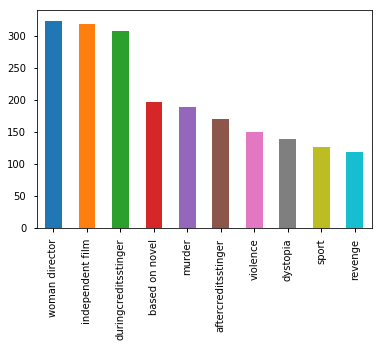

In [41]:
country_count = pd.Series(get_count(tmdb['keywords'])).sort_values(ascending=False)
country_count_show= country_count.head(10)
country_count_show.plot(kind='bar')

# How to Make a Hit Movie

# 4.1) Profit Regression Analysis by Machine Learning

We plan to implement a machine learning analysis inside TMDB data. We wish to analyze the profit as the output for regression. Firstly, we choose the best hyperparameters for the whole training sets by cross validation. Then we plan to use greedy backward selection to choose the top features that affect the profit the movie by corss vailadation.By machine learning, we can get the top features that affect the movie profit.

Here is a machine learning regression algorithm for profit. We wish to explore the features of a movie instead of just money number like budget and revenue.

We choose the following features as the digit feauures. We choose the profit we get in the preprocessing section as the labels for later regression.

In [4]:
tmdb_data=pd.read_pickle('tmdb_data.pkl')
tmdb_ml=tmdb_data.copy()
tmdb_ml.head(1)

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,vote_average,vote_count,director,release_year,profit,title_change
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2787965087,162.0,"[English, Español]",7.2,11800,James Cameron,2009.0,10.763566,1


We take a glacne at the correlation among value features for profit.

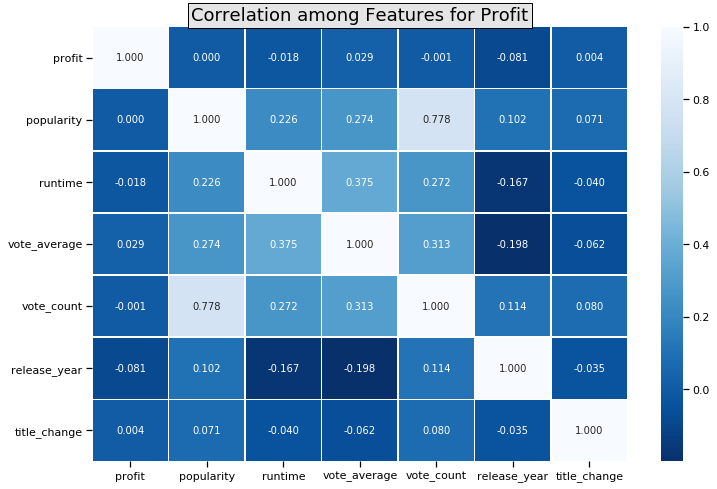

In [10]:
tmdb_cor=tmdb_ml[['profit','popularity','runtime','vote_average','vote_count','release_year','title_change']]
potential_type = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
tmdb_cor = tmdb_cor.select_dtypes(include=potential_type)
plt.figure(figsize=(12, 8))
sns.heatmap(tmdb_cor.corr(), annot = True, fmt = ".3f", linewidths = .5, cmap = 'Blues_r');
plt.title('Correlation among Features for Profit', fontsize=18, bbox={'facecolor':'1.9', 'pad':3})
plt.show()

In [16]:
tmdb_ml = tmdb_data.copy()
features=['popularity','runtime','vote_average','vote_count','release_year','title_change']
labels=['profit']
tmdb_features = tmdb_ml[features]
tmdb_labels=tmdb_ml[labels]

We choose genres, countries, directors and spoken language as factors that may affect the profits. Since the text data are stored in list data structure, we can not use simple get_dummy. Thus we use the same approaches in previous sections. 
Also, because features in low-frequency have much contingency, we only choose the top 10 or 20 in these features. For example, a famous director may influence a movie to a large degree, however, the information of those who direct 1 or 2 movie is not informative and can often lead to outliers or noise in machine learning analysis.

In [19]:
def get_count(col):
    temp_count = dict()
    for row in col:
        for temp_feature in row:
            if temp_feature in temp_count:
                temp_count[temp_feature] += 1
            else:
                temp_count[temp_feature] = 1
    return temp_count

In [20]:
def extract(genres,tmdb_features,number):
    genres_count = pd.Series(get_count(tmdb_data[genres])).sort_values(ascending=False)
    genres_count=genres_count[:number]
    for temp_genre in genres_count.index[:10]:
            tmdb_features[temp_genre]=0
    for temp_genre in genres_count.index:
        for i in range(len(tmdb_features)):
            if temp_genre in tmdb_data['genres'].values[i]:
                tmdb_features[temp_genre].values[i]=1

In [21]:
extract('genres',tmdb_features,20)
extract('production_countries',tmdb_features,10)
extract('spoken_languages',tmdb_features,10)
extract('production_companies',tmdb_features,10)

In [26]:
def get_direcotr_count(col):
    temp_count = dict()
    for temp_director in col:
            if temp_director in temp_count:
                temp_count[temp_director] += 1
            else:
                temp_count[temp_director] = 1
    return temp_count

In [35]:
director_count = pd.Series(get_direcotr_count(tmdb_data['director'])).sort_values(ascending=False)
director_count=director_count[:10]
for temp_director in director_count.index:
    tmdb_features[temp_director]=0
for temp_director in director_count.index:
    for i in range(len(tmdb_features)):
        if temp_director in tmdb_data['director'].values[i]:
            tmdb_features[temp_director].values[i]=1

We get the columns for training features.

In [42]:
tmdb_features.columns

Index(['popularity', 'runtime', 'vote_average', 'vote_count', 'release_year',
       'title_change', 'Drama', 'Comedy', 'Thriller', 'Action', 'Romance',
       'Adventure', 'Crime', 'Science Fiction', 'Horror', 'Family', 'Fantasy',
       'Mystery', 'Animation', 'History', 'Music', 'War', 'Documentary',
       'Western', 'Foreign', 'TV Movie', 'United States of America',
       'United Kingdom', 'Germany', 'France', 'Canada', 'Australia', 'Italy',
       'Spain', 'China', 'Japan', 'English', 'Français', 'Español', 'Deutsch',
       'Italiano', 'Pусский', '普通话', '日本語', 'Português', 'العربية',
       'Warner Bros.', 'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'New Line Cinema', 'Metro-Goldwyn-Mayer (MGM)', 'Touchstone Pictures',
       'Walt Disney Pictures', 'Relativity Media', '', 'Steven Spielberg',
       'Woody Allen', 'Martin Scorsese', 'Clint Eastwood', 'Robert Rodriguez',
       'Ridley Scott', 'Spike Le

In case of extraordinary features, we again use dropna.

In [43]:
tmdb_features=tmdb_features.dropna(how='all')
tmdb_features=tmdb_features.drop('',axis=1)
tmdb_features=tmdb_features.fillna(0)
tmdb_features.head()

,popularity,runtime,vote_average,vote_count,release_year,title_change,Drama,Comedy,Thriller,Action,...,Relativity Media,Steven Spielberg,Woody Allen,Martin Scorsese,Clint Eastwood,Robert Rodriguez,Ridley Scott,Spike Lee,Renny Harlin,Steven Soderbergh
0,150.437577,162.0,7.2,11800,2009.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,139.082615,169.0,6.9,4500,2007.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,107.376788,148.0,6.3,4466,2015.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,112.312950,165.0,7.6,9106,2012.0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,43.926995,132.0,6.1,2124,2012.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


We split the data into training set and testing set with a ratio of 80% and 20 %. Since we will do randomization in later cross validation process. Here we just take the first 80% of raw dataset to training set.

In [44]:
inf_index=tmdb_labels[tmdb_labels['profit']>10].index
tmdb_features=tmdb_features.drop(inf_index,axis=0)
tmdb_labels=tmdb_labels.drop(inf_index,axis=0)
tmdb_labels=tmdb_labels.fillna(0)

In [45]:
max_index=tmdb_labels[tmdb_labels['profit']==max(tmdb_labels['profit'])].index
tmdb_labels=tmdb_labels.drop(max_index)
tmdb_features=tmdb_features.drop(max_index)

In [46]:
tmdb_len=len(tmdb_features)
train_features= tmdb_features[:round( 0.9 * tmdb_len )]
test_features = tmdb_features[round( 0.9 * tmdb_len ):]
train_labels= tmdb_labels[:round( 0.9 * tmdb_len )]
test_labels= tmdb_labels[round( 0.9 * tmdb_len ):]

Then we do the normalization. We calculate the mean and std of each column of feature in training set and use the calculated result to realize the normalization in both training and testing datasets.

In [47]:
for temp_col in tmdb_features.columns:
    temp_mean=train_features[temp_col].mean()
    temp_std=train_features[temp_col].std()
    train_features[temp_col]=(train_features[temp_col]-temp_mean)/temp_std
    test_features[temp_col]=(test_features[temp_col]-temp_mean)/temp_std
train_features=train_features.dropna(how='any')
train_features.head()

,popularity,runtime,vote_average,vote_count,release_year,title_change,Drama,Comedy,Thriller,Action,...,Relativity Media,Steven Spielberg,Woody Allen,Martin Scorsese,Clint Eastwood,Robert Rodriguez,Ridley Scott,Spike Lee,Renny Harlin,Steven Soderbergh
1,3.985178,2.843772,0.769181,3.046598,0.35970,0.229022,-0.954580,-0.76145,-0.622301,1.659385,...,-0.161508,-0.07113,-0.072896,-0.065554,-0.067463,-0.061561,-0.063588,-0.059466,-0.061561,-0.057296
2,2.901219,1.852660,0.171765,3.019144,1.08306,0.229022,-0.954580,-0.76145,-0.622301,1.659385,...,-0.161508,-0.07113,-0.072896,-0.065554,-0.067463,-0.061561,-0.063588,-0.059466,-0.061561,-0.057296
3,3.069977,2.654989,1.466167,6.765737,0.81180,0.229022,1.047317,-0.76145,1.606535,1.659385,...,-0.161508,-0.07113,-0.072896,-0.065554,-0.067463,-0.061561,-0.063588,-0.059466,-0.061561,-0.057296
4,0.731998,1.097528,-0.027374,1.128084,0.81180,0.229022,-0.954580,-0.76145,-0.622301,1.659385,...,-0.161508,-0.07113,-0.072896,-0.065554,-0.067463,-0.061561,-0.063588,-0.059466,-0.061561,-0.057296
5,3.185767,1.427898,-0.226513,2.300509,0.35970,0.229022,-0.954580,-0.76145,-0.622301,1.659385,...,-0.161508,-0.07113,-0.072896,-0.065554,-0.067463,-0.061561,-0.063588,-0.059466,-0.061561,-0.057296


So far we standardize the values of each feature in the data to have mean 0 and variance 1.

We use random forest regressor to deal with the regression. Firstly, we import the library.

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
tmdb_model =  RandomForestRegressor(n_estimators = 20, max_depth=5, oob_score = True)
tmdb_model.fit(train_features,train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

We take a glance of the result of the random forest algorithm,and the main metric of a regression is set as mean squard error (mse). The hyperparameters are chosen randomly.

In [53]:
test_predict_array=tmdb_model.predict(test_features)
test_labels_array=np.array(test_labels['profit'])
temp_mse=mean_squared_error(test_predict_array, test_labels_array) 
print('mean square error is '+str(temp_mse))

mean square error is 1.430923044595997


plot the test result upon running the trained random forest model in testing set 

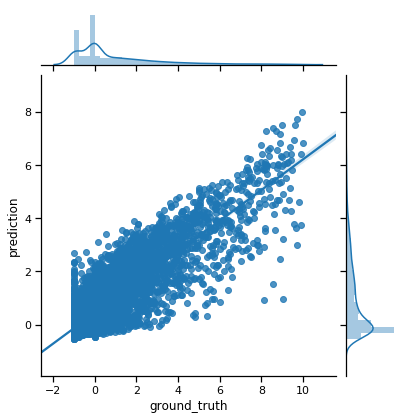

In [62]:
tmdb_pred_label=pd.DataFrame({'ground_truth':test_labels_array,'prediction':test_predict_array})
sns.jointplot(x='ground_truth',y='prediction',data=tmdb_pred_label,kind='reg')

We can see that most prediction and labels have a linear relationship. However, there are too many outliers, and the ranges are not wide enough, which is to say, a simple random forest model with randomly chosen hyperparameters may not be enough to train a regresor, so later we will use grid search, cross validation and greedy backward selection to improve the model and find the top related features.

For later manually created cross validation, we prepare it for a function of data split index, build_k_indices. Among the inputs, y is the data we will split in later cross validation, the k_folder is the number we want to divide our dataset with (in the task k_folder is just 5) and seed is random number. We use np.random.seed to randomize the index in input dataset and use k_indices to split the randomized data into k_folder divisions.

In [54]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [31]:
n_estimators_range=range(10,110,10)
max_depth_range= range(1,21)
ne_score=pd.DataFrame({'n_estimators':np.array(n_estimators_range),'mse':0.0})
mp_score=pd.DataFrame({'max_depth':np.array(max_depth_range),'mse':0.0})
rfc_score= pd.merge(ne_score, mp_score)
rfc_score= rfc_score[['n_estimators','max_depth','mse']]

Also for each potential combination of 2 parameters, we use random forest regressor with cross validation to get the mean square error of the chosen combination, and fill in the accuracy of the dataframe rfc_score in corresponding row. The approach complies to the grid search. And after running all combinations, the output of rfc_score is as follows.

In [32]:
k_indices=build_k_indices(train_labels,5,10)
for i in range(len(rfc_score)):
    score_sum=0
    temp_ne= rfc_score['n_estimators'].values[i]
    temp_mp= rfc_score['max_depth'].values[i]
    for k in range(5):
        temp_valid_indice = k_indices[k]
        temp_train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
        temp_train_indice = temp_train_indice.reshape(-1)
        temp_train_features= train_features.values[temp_train_indice]
        temp_train_labels=train_labels.values[temp_train_indice]
        temp_valid_features=train_features.values[temp_valid_indice] 
        temp_valid_labels=train_labels.values[temp_valid_indice]
        
        temp_rfc = RandomForestRegressor(n_estimators= temp_ne, max_depth= temp_mp)
        temp_rfc.fit(temp_train_features, temp_train_labels)
        temp_valid_pred = temp_rfc.predict(temp_valid_features)
        temp_score=mean_squared_error(temp_valid_labels, temp_valid_pred) 
        score_sum=score_sum+temp_score
    temp_mse= score_sum/5
    rfc_score['mse'].values[i]= temp_mse
rfc_score.head()
        

,n_estimators,max_depth,mse
0,10,1,3.731611
1,10,2,3.439110
2,10,3,3.235889
3,10,4,3.174362
4,10,5,3.165719


For more intuitive observation of grid search, we get a 3D terrain plot for the 2 hyperparameters, with the height z set as the value of mse.

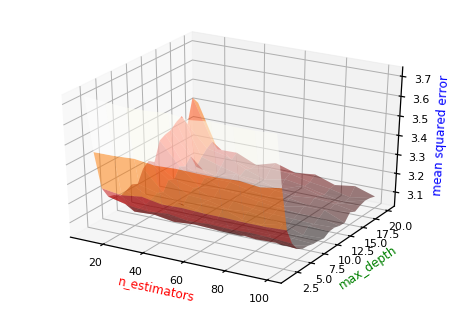

In [33]:
from mpl_toolkits.mplot3d import Axes3D
temp_fig=plt.figure()
temp_ax=Axes3D(temp_fig)
temp_x=np.array(range(10,110,10))
temp_y=np.array(range(1,21))
temp_x, temp_y = np.meshgrid(temp_x, temp_y)
temp_z=np.ones([20,10])
for i in range(len(temp_x)): # number of max_depth
    for j in range(len(temp_x[0])): # number of n_estimators
        temp_ne=temp_x[0][j]
        temp_md=temp_y[i][0]
        temp_df=rfc_score[rfc_score['n_estimators']==temp_ne] 
        temp_df=temp_df[temp_df['max_depth']==temp_md]
        temp_mse=temp_df['mse'].values[0]
        temp_z[i][j]=temp_mse
temp_ax.plot_surface(temp_x, temp_y, temp_z, rstride = 1, cstride = 1, cmap=plt.cm.hot,alpha=0.5)
temp_ax.set_xlabel('n_estimators', color='r')
temp_ax.set_ylabel('max_depth', color='g')
temp_ax.set_zlabel('mean squared error', color='b')
temp_fig.show()

In [34]:
rfc_score_min=min(rfc_score['mse'])
best_ne= rfc_score[rfc_score['mse']==rfc_score_min]['n_estimators'].values[0]
best_md= rfc_score[rfc_score['mse']==rfc_score_min]['max_depth'].values[0]
print('the best n_estimators for the model: '+str(best_ne))
print('the best max_depth for the model: '+str(best_md))

the best n_estimators for the model: 90
the best max_depth for the model: 10


We define function to get the mse metric of selected features training compared with true labels with the method of training random forest regressor with 5-cross-validation.  

In [35]:
def rfr_mse_cv5(features,labels):
    score_sum=0
    k_indices=build_k_indices(labels,5,10)
    for k in range(5):       
        temp_valid_indice = k_indices[k]
        temp_train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
        temp_train_indice = temp_train_indice.reshape(-1)
        temp_train_features= features.values[temp_train_indice]
        temp_train_labels=labels.values[temp_train_indice]
        temp_valid_features=features.values[temp_valid_indice] 
        temp_valid_labels=labels.values[temp_valid_indice]  
        temp_model =  RandomForestRegressor(n_estimators = best_ne, max_depth=best_md, oob_score = True )
        temp_model.fit(temp_train_features,temp_train_labels)
        temp_valid_pred = temp_model.predict(temp_valid_features)                
        temp_score = mean_squared_error(temp_valid_labels, temp_valid_pred) 
        score_sum=score_sum+temp_score
    return score_sum/5

Upon finishing defining the functions above, we use greedy backward selection to iteratively remove features one by one. Our code creates a dataframe features_select with each potential feature of 65 in each row and its corresponding mse, which is initialized as 0.0. A list remove_feature is also defined and initialized empty. Then our code use the remove_feature to restore the removed features in each iteration. From the iteration 1 to 65, we choose each of the features remained in the dataframe, and combine the temporary single feature with the removed feature in the remove_feature to form a combination of temp_train_feature. After fitting them with training labels by random forest regressor, we can get the mse (chosen as main metric) of each remained single feature combined with the features already moved in remove_feature. Our code sort the dataframe by mse value on descending order. Then we can remove the one feature with the largest mse value, which is to say, that feature contributing least to the prediction combined with features already removed. And the dataframe updates itself by deleting the first row (corresponding to the feature decided to be removed in this iteration). That feature is also added to remove_feature to the next iteration. The iteration is not over until the dataframe features_select has the last one feature.The code approach complies to defination of greedy backward selection to remove features one by one. 

In [36]:
features_select = pd.DataFrame({'feature':np.array(train_features.columns),'mse':0.0})
temp_features_select=features_select.copy()
remove_feature=[]
remove_score=[]
while len(temp_features_select)>0:
    for i in range(len(temp_features_select)):
        temp_feature=temp_features_select['feature'].values[i]
        temp_train_feature=remove_feature+ [temp_feature]
        temp_score=rfr_mse_cv5(train_features[temp_train_feature],train_labels)
        temp_features_select['mse'].values[i]= temp_score
    temp_features_select=temp_features_select[['feature','mse']].sort_values(ascending=False, by='mse')
    temp_features_select.reset_index(inplace=True)
    temp_features_select=temp_features_select[['feature','mse']]
    temp_remove_feature=temp_features_select['feature'].values[0]
    temp_remove_score=temp_features_select['mse'].values[0]
    k=len(temp_features_select)
    features_select['feature'].values[65-k]= temp_remove_feature
    remove_feature=remove_feature + [temp_remove_feature]
    remove_score=remove_score+[temp_remove_score]
    temp_features_select=temp_features_select[1:]
    temp_features_select.reset_index(inplace=True)
    temp_features_select=temp_features_select[['feature','mse']]
select_features=remove_feature[::-1]
select_features

['vote_count',
 'popularity',
 'vote_average',
 'Drama',
 'New Line Cinema',
 'United States of America',
 'Twentieth Century Fox Film Corporation',
 'Universal Pictures',
 'Canada',
 'Science Fiction',
 'History',
 'English',
 'title_change',
 'Music',
 'Comedy',
 'Animation',
 'Thriller',
 'War',
 'Romance',
 'Paramount Pictures',
 'Steven Spielberg',
 'Metro-Goldwyn-Mayer (MGM)',
 'Pусский',
 'Horror',
 'Walt Disney Pictures',
 'France',
 'Español',
 'Western',
 'Crime',
 'Italy',
 'Mystery',
 'Woody Allen',
 'Germany',
 'Relativity Media',
 'Columbia Pictures',
 'العربية',
 'Touchstone Pictures',
 'Português',
 'Italiano',
 'Deutsch',
 '日本語',
 'Fantasy',
 'Japan',
 'Australia',
 'Documentary',
 'Spain',
 '普通话',
 'United Kingdom',
 'China',
 'Clint Eastwood',
 'Warner Bros.',
 'Foreign',
 'Family',
 'Robert Rodriguez',
 'Français',
 'Steven Soderbergh',
 'Ridley Scott',
 'Renny Harlin',
 'Martin Scorsese',
 'TV Movie',
 'Spike Lee',
 'Action',
 'Adventure',
 'release_year',
 'runtim

Our main aim is not to create a perfect model for the dataset, but to find the top feautures that affect the movie profit most.
Here we finish the getting the features order in importance for the regression of profit proportion by inversing the order of backward list.In value features, vote and popularity affect the profit most, which conforms to our intuitive assunption. Among non-value features, a profitable movie is mostly influenced by whether a movie is a drama, whether it's produced by companies like New Line Cinema or Twentieth Century Fox Film Corporation or whether it's produced in North America. Relatively, the language and director do not affect the movie profits as much as a company do, since the profit is the company's intenstion for making movies, which also conform to intuitive assumption.

# 4.2) Rating Classification Analysis by Machine Learning

We plan to implement a machine learning analysis in merged data of Amazon rate and TMDB features. We wish to analyze the average rate as the output for regression. Firstly, we choose the best hyperparameters for the whole training sets by cross validation and grid search. Then we use greedy selection to choose the top features that affect the ratings by corss vailadation.By machine learning, we can get the top features that affect Amazon ratings.

In [36]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import *
plotly.tools.set_credentials_file(username='zx_haowan', api_key='J4Agcce1dOjvqiKRTpoO')

In [40]:
merge_raw=pd.read_pickle('merge_raw.pkl')
merge_ml=merge_raw.copy()
merge_ml.head(1)

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,related,asin,reviewText,reviewerName,helpful,summary,overall,reviewerID,unixReviewTime,reviewTime
0,The Chronicles of Narnia: Prince Caspian,"[Ben Barnes, William Moseley, Anna Popplewell,...",225000000,"[Adventure, Family, Fantasy]","[based on novel, fictional place, brother sist...",en,53.978602,"[Walt Disney, Walden Media, Stillking Films, O...","[Czech Republic, Poland, Slovenia, United Stat...",419651413,...,"{'bought_together': ['B000E8M0VA', 'B004M1A21K...",B00005JPH2,Highly recommended for parents and children. ...,"1gewehr ""1gewehr""","[0, 0]",Lots of action and adventure,4.0,A2FI56P3ZSOUWG,1377043200,"08 21, 2013"


We treat it as a regression problem. Compard with TMDB data, we require different features. In this step, we turn tget the year values of column reviewTime and create other value features.

In [41]:
merge_ml=merge_raw.copy()
merge_ml.overall= [int(temp_overall) for temp_overall in merge_ml.overall]
merge_ml.reviewTime=[int(temp_review_time[-4:]) for temp_review_time in merge_ml.reviewTime]
merge_ml.head(1)

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,related,asin,reviewText,reviewerName,helpful,summary,overall,reviewerID,unixReviewTime,reviewTime
0,The Chronicles of Narnia: Prince Caspian,"[Ben Barnes, William Moseley, Anna Popplewell,...",225000000,"[Adventure, Family, Fantasy]","[based on novel, fictional place, brother sist...",en,53.978602,"[Walt Disney, Walden Media, Stillking Films, O...","[Czech Republic, Poland, Slovenia, United Stat...",419651413,...,"{'bought_together': ['B000E8M0VA', 'B004M1A21K...",B00005JPH2,Highly recommended for parents and children. ...,"1gewehr ""1gewehr""","[0, 0]",Lots of action and adventure,4,A2FI56P3ZSOUWG,1377043200,2013


We choose the following features as the digit features. Compared with previous regression, we need more features like budget, revenue, reviewTime and prodcution companies. We choose the overall we get as the labels for later regression.

In [42]:
merge_ml['summary_length']=[len(temp_summary) for temp_summary in merge_ml.summary]
merge_ml['review_length']=[len(temp_review) for temp_review in merge_ml.reviewText]
merge_ml['helpful_1']=[temp_helpful[0] for temp_helpful in merge_ml.helpful]
merge_ml['helpful_2']=[temp_helpful[1] for temp_helpful in merge_ml.helpful]

In [43]:
merge_ml.profit[merge_ml.profit>10]=10
merge_ml=merge_ml.fillna(0)
merge_ml=merge_ml.groupby('title').mean()
merge_ml.head(2)

,budget,popularity,revenue,runtime,vote_average,vote_count,release_year,profit,title_change,salesRank,price,overall,unixReviewTime,reviewTime,summary_length,review_length,helpful_1,helpful_2
title,,,,,,,,,,,,,,,,,,
11:14,6000000.0,15.048067,0.0,86.0,6.8,206.0,2003.0,-1.000000,1.0,75977.0,5.00,4.185714,1.222244e+09,2008.20000,26.985714,1049.342857,2.957143,4.685714
1408,25000000.0,35.169779,94679598.0,104.0,6.5,1343.0,2007.0,2.787184,1.0,1100028.0,2.99,3.726190,1.257872e+09,2009.31746,29.777778,1149.976190,3.448413,5.119048


In [44]:
merge_ml.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'release_year', 'profit', 'title_change', 'salesRank',
       'price', 'overall', 'unixReviewTime', 'reviewTime', 'summary_length',
       'review_length', 'helpful_1', 'helpful_2'],
      dtype='object')

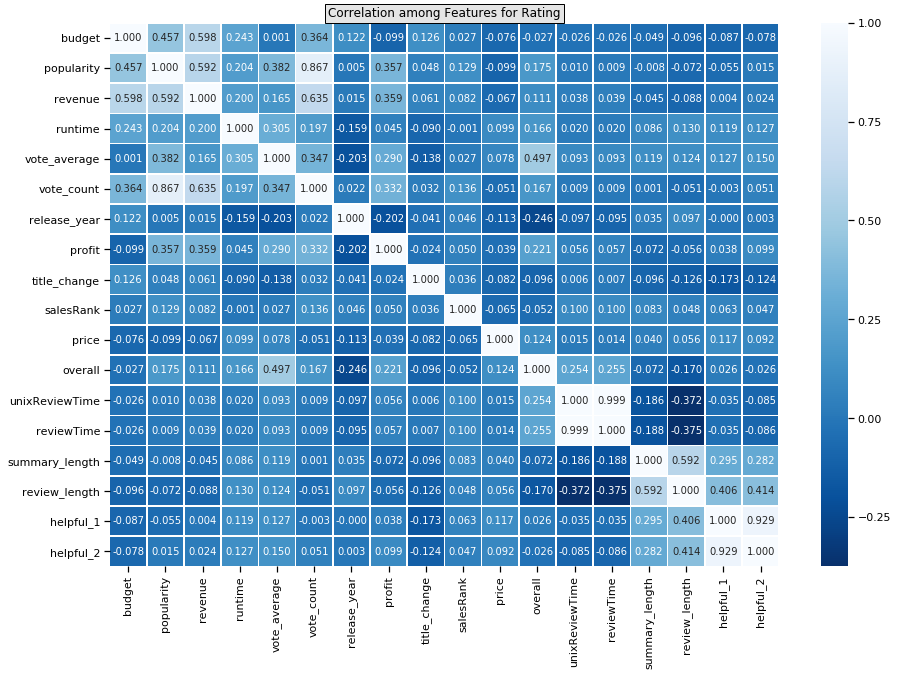

In [45]:
potential_type = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
merge_ml = merge_ml.select_dtypes(include=potential_type)
plt.figure(figsize=(15, 10))
sns.heatmap(merge_ml.corr(), annot = True, fmt = ".3f", linewidths = .5, cmap = 'Blues_r');
plt.title('Correlation among Features for Rating', fontsize=12, bbox={'facecolor':'1.9', 'pad':3})
plt.show()

Again, we take a glacne at the correlation among value features for rating.

In [46]:
temp_feature=['budget','revenue','profit','popularity','runtime','vote_average', 'vote_count','release_year','title_change','price',
             'reviewTime','review_length','summary_length','helpful_1','helpful_2']
temp_label=['overall']
merge_features = merge_ml[temp_feature]
merge_labels=merge_ml[temp_label]

We split the data into training set and testing set with a ratio of 80% and 20 %. Since we will do randomization in later cross validation process. Here we just take the first 80% of raw dataset to training set.In case of extraordinary features, we again use dropna.

In [47]:
merge_len=len(merge_features)
train_features= merge_features[:round( 0.8 * merge_len )]
test_features = merge_features[round( 0.8 * merge_len ):]
train_labels= merge_labels[:round( 0.8 * merge_len )]
test_labels= merge_labels[round( 0.8 * merge_len ):]

Then we do the normalization. We calculate the mean and std of each column of feature in training set and use the calculated result to realize the normalization in both training and testing datasets

In [48]:
for temp_col in merge_features.columns:
    temp_mean=train_features[temp_col].mean()
    temp_std=train_features[temp_col].std()
    train_features[temp_col]=(train_features[temp_col]-temp_mean)/temp_std
    test_features[temp_col]=(test_features[temp_col]-temp_mean)/temp_std

In [49]:
train_features=train_features.dropna(how='all',axis=0)
train_features=train_features.fillna(0)
test_features=test_features.dropna(how='all',axis=0)
test_features=test_features.fillna(0)

We use support vector regressor (svr) to deal with the regression

In [50]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [68]:
gamma_range=np.logspace(-5,5,11)
c_range= np.logspace(-5,5,11)
gamma_score=pd.DataFrame({'gamma':gamma_range,'mse':0.0})
c_score=pd.DataFrame({'c':c_range,'mse':0.0})
svr_score= pd.merge(gamma_score, c_score)
svr_score= svr_score[['gamma','c','mse']]

For each potential combination of 2 parameters, we use support vector regressor with cross validation to get the mean square error of the chosen combination, and fill in the accuracy of the dataframe svr_score in corresponding row. The approach complies to the grid search. And after running all combinations, the output of rfc_score is as follows.

In [69]:
k_indices=build_k_indices(train_labels,5,10)
for i in range(len(svr_score)):
    score_sum=0
    temp_gamma= svr_score['gamma'].values[i]
    temp_c= svr_score['c'].values[i]
    for k in range(5):
        temp_valid_indice = k_indices[k]
        temp_train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
        temp_train_indice = temp_train_indice.reshape(-1)
        temp_train_features= train_features.values[temp_train_indice]
        temp_train_labels=train_labels.values[temp_train_indice]
        temp_valid_features=train_features.values[temp_valid_indice] 
        temp_valid_labels=train_labels.values[temp_valid_indice]
        
        temp_svr = SVR(kernel='rbf', C=temp_c, gamma=temp_gamma)
        temp_svr.fit(temp_train_features, temp_train_labels)
        temp_valid_pred = temp_svr.predict(temp_valid_features)
        temp_score=mean_squared_error(temp_valid_labels, temp_valid_pred) 
        score_sum=score_sum+temp_score
    temp_mse= score_sum/5
    svr_score['mse'].values[i]= temp_mse
svr_score.head()
        

,gamma,c,mse
0,0.00001,0.00001,0.311092
1,0.00001,0.00010,0.311091
2,0.00001,0.00100,0.311084
3,0.00001,0.01000,0.311020
4,0.00001,0.10000,0.310351


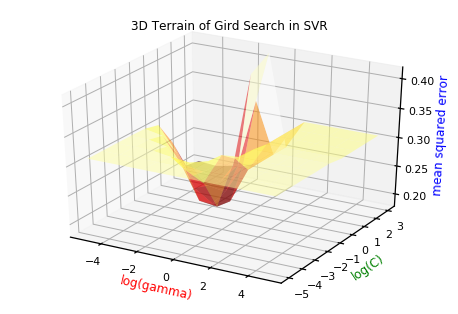

In [72]:
from mpl_toolkits.mplot3d import Axes3D
temp_fig=plt.figure()
temp_ax=Axes3D(temp_fig)
temp_x=np.array(range(-5,6))
temp_y=np.array(range(-5,4))
temp_x, temp_y = np.meshgrid(temp_x, temp_y)
temp_z=np.ones([9,11])
for i in range(len(temp_x)):
    for j in range(len(temp_x[0])):
        x=temp_x[0][j]
        y=temp_y[i][0]
        x=float(x)
        y=float(y)      
        temp_gamma=10**(x)
        temp_c=10**(y)
        temp_df=svr_score[svr_score['gamma']==temp_gamma] 
        temp_df=temp_df[temp_df['c']==temp_c]
        temp_mse=temp_df['mse'].values[0]
        temp_z[i][j]=temp_mse
temp_ax.plot_surface(temp_x, temp_y, temp_z, rstride = 1, cstride = 1, cmap=plt.cm.hot,alpha=0.5)
temp_ax.set_title('3D Terrain of Gird Search in SVR')
temp_ax.set_xlabel('log(gamma)', color='r')
temp_ax.set_ylabel('log(C)', color='g')
temp_ax.set_zlabel('mean squared error', color='b')
temp_fig.show()

get the 3D terrain figure for the 2 hyperparameters, with the height z set as the value of mse

Also, we use plotly to get an interactive 3D terrain surface figure for a more intuitvie obervatoin of grid search.

In [73]:
svr_score_log=svr_score.copy()
svr_score_log['gamma']=np.log10(svr_score_log['gamma'])
svr_score_log['c']=np.log10(svr_score_log['c'])

In [74]:
svr_3d=pd.DataFrame(columns=range(-5,6),index=range(-5,6))
for col in svr_3d.columns:
    for row in svr_3d.index:
        temp_gamma=col
        temp_c=row
        temp_values=svr_score_log[svr_score_log['gamma']==temp_gamma]
        temp_values=temp_values[temp_values.c==temp_c]
        temp_value=temp_values.mse.values[0]
        svr_3d[col][row]=temp_value

We turn the data strcture for the input of plotly 3D surface figure.

In [95]:
data = [go.Surface(z=svr_3d.as_matrix() )]
layout = go.Layout(
    #scene = list(xaxis = list(title = 'log10(gamma)+5'))
    xaxis=dict(title="log10(gamma)+5",autorange=False,range=[-5,5],type='linear', ),
    yaxis=dict(title='log10(C)+5' ,showgrid=False, ),
    title='3D Terrain of Gird Search in SVR (x:log10(gamma)+5, y:log10(C)+5)',
    autosize=False,
    width=600,height=600,
    margin=dict(l=65,r=50,b=65,t=90))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='3D Terrain of Gird Search in SVR')

The plotly figure is stored in 'plotly_image/3D Terrain of Gird Search in SVR.html' in github.

Upon that we can get the best hyperparameter for gamma and penalty C by a more interactive terrain surface.

In [76]:
svr_score_min=min(svr_score['mse'])
best_gamma= svr_score[svr_score['mse']==svr_score_min]['gamma'].values[0]
best_c= svr_score[svr_score['mse']==svr_score_min]['c'].values[0]
print('the best gamma for the model: '+str(best_gamma))
print('the best C for the model: '+str(best_c))

the best gamma for the model: 0.01
the best C for the model: 1.0


We define function to get the mse metric of selected features training compared with true labels with the method of training support vector regressor with 5-cross-validation.

In [77]:
def svr_mse_cv5(features,labels):
    score_sum=0
    k_indices=build_k_indices(labels,5,10)
    for k in range(5):       
        temp_valid_indice = k_indices[k]
        temp_train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
        temp_train_indice = temp_train_indice.reshape(-1)
        temp_train_features= features.values[temp_train_indice]
        temp_train_labels=labels.values[temp_train_indice]
        temp_valid_features=features.values[temp_valid_indice] 
        temp_valid_labels=labels.values[temp_valid_indice]  
        temp_model =  SVR(kernel='rbf', C=best_c, gamma=best_gamma)
        temp_model.fit(temp_train_features,temp_train_labels)
        temp_valid_pred = temp_model.predict(temp_valid_features)                
        temp_score = mean_squared_error(temp_valid_labels, temp_valid_pred) 
        score_sum=score_sum+temp_score
    return score_sum/5

Then we use greedy selection to iteratively select features one by one. Our code creates a dataframe features_select with each potential value feature in each row and its corresponding mse, which is initialized as 0.0. A list select_feature is also defined and initialized empty. Our code use the select_feature to restore the selected features in each iteration. From the iterations, we choose each of the features remained in the dataframe, and combine the temporary single feature with the selected feature in the select_feature to form a combination of temp_train_feature. After fitting them with training labels by support vector regressor, we can get the mse (chosen as main metric) of each remained single feature combined with the features already moved in select_feature. Our code sort the dataframe by mse value on ascending order. Then we can select the one feature with the smallest accuracy value, which is to say, that feature contributing most to the prediction combined with features already selected. And the dataframe updates itself by deleting the first row (corresponding to the feature decided to be selected in this iteration). That feature is also added to select_feature to the next iteration. The iteration is not over until the dataframe features_select has the last one feature.The code approach complies to defination of greedy selection to select features one by one. 

In [78]:
features_select = pd.DataFrame({'feature':np.array(train_features.columns),'mse':0.0})
temp_features_select=features_select.copy()
select_feature=[]
select_score=[]
while len(temp_features_select)>0:
    for i in range(len(temp_features_select)):
        temp_feature=temp_features_select['feature'].values[i]
        temp_train_feature=select_feature+ [temp_feature]
        temp_score=svr_mse_cv5(train_features[temp_train_feature],train_labels)
        temp_features_select['mse'].values[i]= temp_score
    temp_features_select=temp_features_select[['feature','mse']].sort_values(ascending=True, by='mse')
    temp_features_select.reset_index(inplace=True)
    temp_features_select=temp_features_select[['feature','mse']]
    temp_select_feature=temp_features_select['feature'].values[0]
    temp_select_score=temp_features_select['mse'].values[0]
    k=len(temp_features_select)
    features_select['feature'].values[15-k]= temp_select_feature
    select_feature=select_feature + [temp_select_feature]
    select_score=select_score+[temp_select_score]
    temp_features_select=temp_features_select[1:]
    temp_features_select.reset_index(inplace=True)
    temp_features_select=temp_features_select[['feature','mse']]
select_feature

['vote_average',
 'review_length',
 'release_year',
 'reviewTime',
 'title_change',
 'summary_length',
 'price',
 'budget',
 'runtime',
 'helpful_2',
 'helpful_1',
 'revenue',
 'profit',
 'vote_count',
 'popularity']

Here we get the order of value feature that affect the movie ratings.

In [79]:
test_features_score = pd.DataFrame({'feature_number':range(1,16) , 'test_mse':0.0,'cross_validation_mse' :np.array(select_score) })
k=0
for i in range(1,16):
    temp_train_features = select_feature[:i+1]
    temp_model =  SVR(kernel='rbf', C=best_c, gamma=best_gamma)
    temp_model.fit(train_features[temp_train_features], train_labels)
    temp_test_pred = temp_model.predict(test_features[temp_train_features])
    temp_score = mean_squared_error(temp_test_pred, test_labels) 
    test_features_score['test_mse'][k] = temp_score
    k=k+1

To verify the most important features, we use a line plot to get an intuitive visualization of the performance of selected features in cross validatoin and test set.

In [80]:
mse_list=['cross_validation_mse','test_mse']
potantial_color=['#b3cde3','#fbb4ae']
temp_line=[]
for ind, mse in enumerate(mse_list):
    temp_line.append(
        go.Scatter(
            x=test_features_score.feature_number,
            y=test_features_score[mse],
            name=mse,legendgroup=mse,
            line = dict(color = (potantial_color[ind]),width = 3),), )
layout = go.Layout( autosize=True, title='CV MSE vs Test MSE',)
fig = go.Figure(data=temp_line,layout=layout)

py.iplot(fig,filename='CV MSE vs Test MSE')

The plotly figure is stored in 'plotly_image/CV MSE vs Test MSE.html' in github.

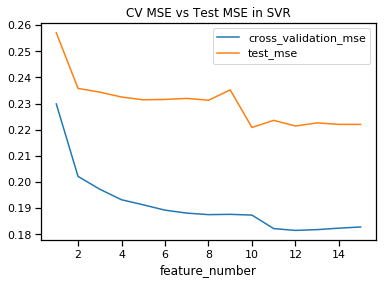

In [82]:
plt.plot( test_features_score['feature_number'],test_features_score['cross_validation_mse'])
plt.legend()
plt.plot( test_features_score['feature_number'],test_features_score['test_mse'])
plt.legend()
plt.title('CV MSE vs Test MSE in SVR')
plt.xlabel('feature_number')
plt.show()

The performance with different number of feature selected have a similar trend in validation set and test set. The curve flattens after feature number at 6 and then falls at around 10. The most obvious fall happen in the first several numbers, which is to say that the first 6 value features could predict the average rating with acceptable mean square value.

To verify our assumption, we select the top 6 features and again train in cross validation and test in testing set by support vector model with chosen grid searched hyperparameters.

In [83]:
features=['vote_average','review_length','release_year', 'reviewTime', 'title_change','summary_length']
merge_features=merge_ml[features]
merge_labels=merge_ml['overall']
merge_len=len(merge_features)
train_features= merge_features[:round( 0.8 * merge_len )]
test_features = merge_features[round( 0.8 * merge_len ):]
train_labels= merge_labels[:round( 0.8 * merge_len )]
test_labels= merge_labels[round( 0.8 * merge_len ):]
for temp_col in merge_features.columns:
    temp_mean=train_features[temp_col].mean()
    temp_std=train_features[temp_col].std()
    train_features[temp_col]=(train_features[temp_col]-temp_mean)/temp_std
    test_features[temp_col]=(test_features[temp_col]-temp_mean)/temp_std

In [84]:
temp_model =  SVR(kernel='rbf', C=best_c, gamma=best_gamma)
temp_model.fit(train_features,train_labels)
temp_pred = temp_model.predict(test_features)

In [88]:
test_predict_array=temp_model.predict(merge_features)
test_labels_array=np.array(merge_labels)
merge_pred_label=pd.DataFrame({'ground_truth':test_labels_array,'prediction':test_predict_array,'count':range(len(merge_labels))})

In [89]:
label_list=['ground_truth','prediction']
potantial_color=['#b3cde3','#fbb4ae']
temp_line=[]
for ind, label in enumerate(label_list):
    temp_line.append(
        go.Scatter(
            x=merge_pred_label['count'],
            y=merge_pred_label[label],
            name=label,legendgroup=label,
            line = dict(color = (potantial_color[ind]),width = 1),), )
layout = go.Layout( autosize=True, title='Ground Truth vs Prediction in Test Set',)
fig = go.Figure(data=temp_line,layout=layout)
#temp_line.layout['legend']=dict( orientation="h", y=1.2,font=dict(size=7, ),)

py.iplot(fig, filename='ground_truth_vs_prediction')

The plotly figure is stored in 'plotly_image/ground_truth_vs_prediction.html' in github.

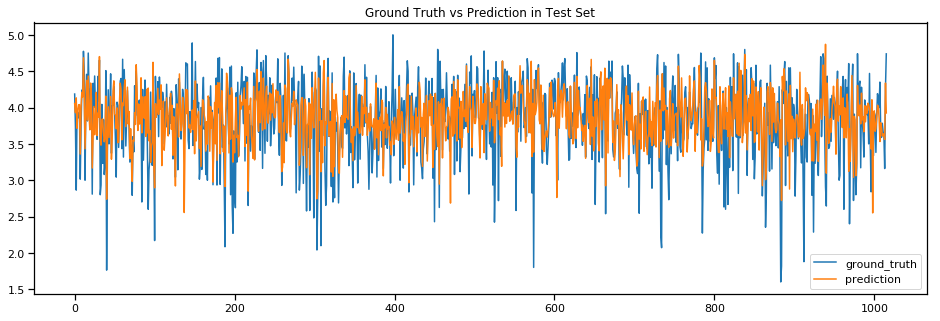

In [90]:
plt.figure(figsize=(16,5))
plt.plot( merge_pred_label['count'],merge_pred_label['ground_truth'])
plt.legend()
plt.plot( merge_pred_label['count'],merge_pred_label['prediction'])
plt.title('Ground Truth vs Prediction in Test Set')
plt.legend()

We get the curve of ground_truth label and prediction in plt and plotly. We can also observe that the main trend of the curves are similar, and the average difference between each testing data point is not far, which is to say our model with 6 selected features have an acceptable performance. Since our aim is not to make a perfect machine learning model, but to find the top features that affect rating most, the selected features through support vector regressor can comply to our goal.

For further proof of assumption,we get the cumulative value in the dataset and choose the first 50 for better observation of prediction performance. Also a kde figure is plotted.

In [91]:
merge_pred_label['ground_truth_sum']=0.0
merge_pred_label['prediction_sum']=0.0
sum_gt=0.0
sum_pred=0.0
for i in range(len(merge_pred_label)):
    sum_gt=sum_gt+merge_pred_label.ground_truth.values[i]
    merge_pred_label['ground_truth_sum'][i]=sum_gt
    sum_pred=sum_pred+merge_pred_label.prediction.values[i]
    merge_pred_label['prediction_sum'][i]=sum_pred

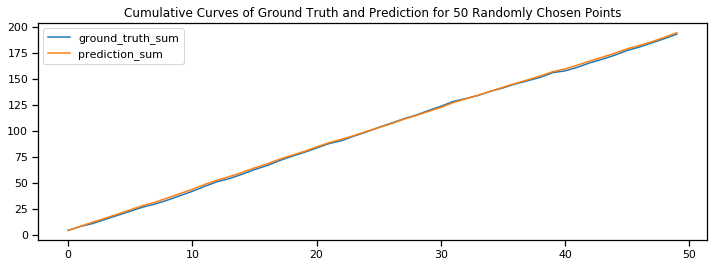

In [92]:
show_pred_label=merge_pred_label.iloc[:50]
plt.figure(figsize=(12,4))
plt.plot( show_pred_label['count'],show_pred_label['ground_truth_sum'])
plt.legend()
plt.plot( show_pred_label['count'],show_pred_label['prediction_sum'])
plt.title('Cumulative Curves of Ground Truth and Prediction for 50 Randomly Chosen Points')
plt.legend()

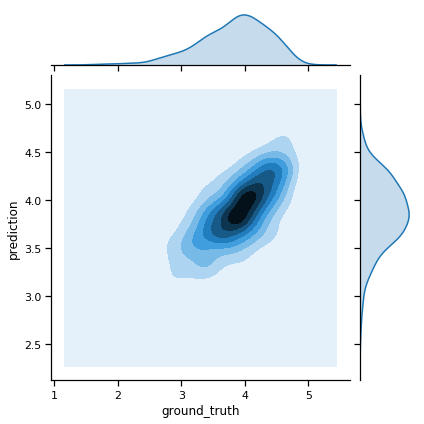

In [98]:
sns.jointplot(x='ground_truth',y='prediction',title='KDE Plot for Ground Truth and Prediction',data=merge_pred_label,kind='kde')
plt.show()

From the observation, although there exist some outliers and difference between ground truth labels and model predictions, most predcitions conform to the same trend with the labels, for example, the 2 line plots almost overlap despite some little distance between the lines.
We admit our machine learning model is not perfect and have a large space for improvement, but we have realizaed our target to choose the top features related to Amazon average rating.

So far we have used the called 'black box' machine learning model to get the top value features that affect the ratingss. Later we will go a bit further in analysis of relationship between single feature with the ratings.

# Milestone 2 Conclusion

1) Finish data loading from TMDB Datasets and Amazon Datasets, and implement data wrangling and cleaning according to the characteristics of each dataset(including enrich, filter, transform). Thus we are more aware of the datasets and future implementations in the project

2) Do data preprocessing and merge for each dataset for future potential analysis approaches and save the preprocessed dataframes into a pickle file for futher efficient use

3) Implement necessary descriptive statistics tasks in seperate dataframes and corresponding visualization for potentially informative features for further analysis.

4) Design the machine learning appraoch inside TMDB dataset and merged dataset to implement regression of movie profit and Amazon rating classification, as well as the approaches of hyperparameter tuning and greedy selection for most informative features that affect the movies

5) More aware of the datasets and future implementations in the project and made future plans in the project until milestone 3

# A list of internal milestones up until project milestone 3

1) Complete and optimize the machine learning approaches, utilize greedy selection to select features that affect movies profit and correponding Amazon reviews

2) Implement more text data analysis with text processing approaches

3) Analyze the features at higher level with detailed exploration 

4) Finish data report with exlusive analysis and explanantion